In [1]:
import numpy as np
import matplotlib.pyplot as plt
from constants import NP_DATASET_PATH, NP_DATASET_KMEANS_PATH

# read data

In [2]:
np2img = lambda x: ((x - x.min()) / (x.max() - x.min()) * 255).astype(np.uint8)

int2gesture = {
    0: 'neutral',
    1: 'flexion',
    2: 'extension',
    7: 'fist'
}

'''
!!!
Raw k-means labels are not semantically meaningful i.e. you know sample x belongs to cluster/label 3, but you don't know to which gesture
that label refers to. The below values were experimentally verified on my own dataset and won't be correct for yours.
!!!
'''
kint2gesture = {
    2: 'neutral',
    0: 'flexion',
    1: 'extension',
    3: 'fist'
}

gesture2intensity = {
    'neutral': 20,
    'flexion': 64,
    'extension': 128,
    'fist': 255
}

kdata = np.load(NP_DATASET_KMEANS_PATH)
kX = kdata['X']
ky = kdata['y']

data = np.load(NP_DATASET_PATH)
X = data['X']
y = data['y']

np.any(kX != X)

False

# visualize data

/tmp/ipykernel_27948/2134440384.py:40: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  samples_plot = ax.pcolormesh(th, r, samples)
/tmp/ipykernel_27948/2134440384.py:64: MatplotlibDeprecationWarning: Passing argument *p* of unexpected type Line2D to add_patch which only accepts <class 'matplotlib.patches.Patch'> is deprecated since 3.5 and will become an error two minor releases later.
  ax.add_patch(sep)


(0.0, 6.283185307179586, 0.0, 1.3663184967041015)

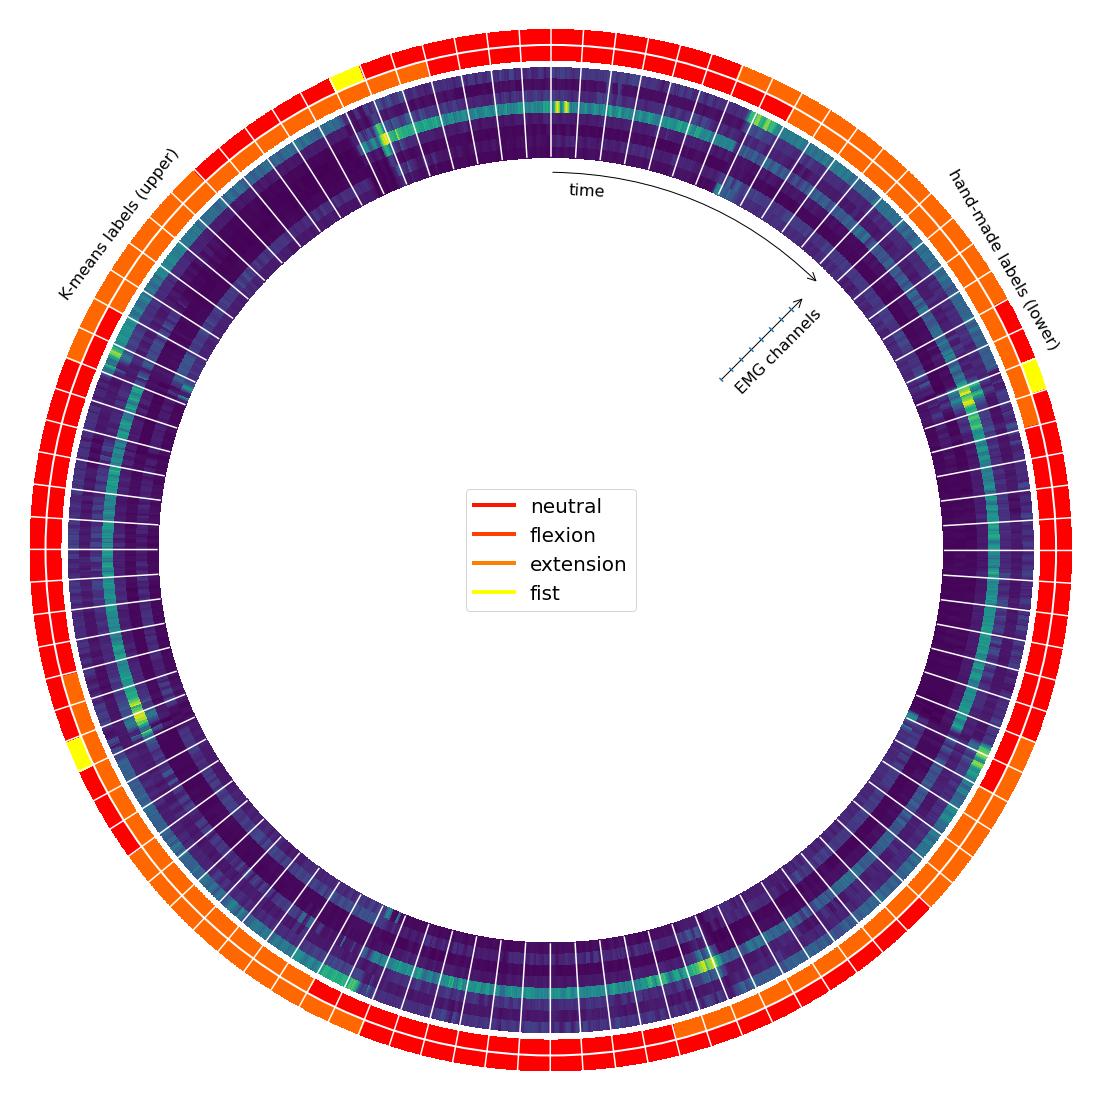

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.legend import Line2D

# how many samples you watn to view
N = 100
# offset wrt total number of samples
K = 2354

CHANNELS = 8

labels, klabels = [], []

samples = []
for i in range(K, K + N):
  # remove overlap
  sample = np.concatenate([X[i - 1, -10:], X[i, :20]], axis=0)
  labels.append(y[i].item())
  klabels.append(ky[i].item())
  samples.append(sample)

samples = np.concatenate(samples, axis=0)

# prepare polar coordinates
rad = np.linspace(1, 1.2, CHANNELS)
thetas = np.linspace(0, 2 * np.pi, len(samples))
r, th = np.meshgrid(rad, thetas)

labels_heatmap = np.zeros((len(samples), 2), dtype=np.uint8)
for i in range(len(samples)):
  labels_heatmap[i, 0] = gesture2intensity[int2gesture[y[K + i // 30]]]
  labels_heatmap[i, 1] = gesture2intensity[kint2gesture[ky[K + i // 30]]]

fig, ax = plt.subplots(1, 1, figsize=(20, 20), subplot_kw={'polar': True})

fig.gca().set_theta_zero_location('N')
fig.gca().set_theta_direction(-1)

# plot data
samples_plot = ax.pcolormesh(th, r, samples)

# plot labels
labels_rad = [1.25, 1.29]
labels_r, labels_th = np.meshgrid(labels_rad, thetas)
cmap = plt.cm.autumn
labels_plot = ax.pcolormesh(labels_th, labels_r, labels_heatmap, cmap=cmap)
legend_elements = [Line2D([0], [0], color=cmap(v), lw=4) for v in gesture2intensity.values()]
ax.legend(legend_elements, [k for k in gesture2intensity.keys()], loc='center', prop={'size': 20})

circle = plt.Circle((0., 0.), 1.27, transform=ax.transData._b, fill=False, edgecolor='white', linewidth=2)
ax.add_patch(circle)

# annotations
time_arrow = patches.FancyArrowPatch((np.pi/4, 0.95), (0., 0.95), arrowstyle='<-, head_width=4, head_length=8',
                             connectionstyle="arc3, rad=0.2")

emg_arrow_start_r, emg_arrow_end_r = 0.6, 0.9
emg_arrow_theta = np.pi/4
emg_channels_arrow = patches.FancyArrowPatch((emg_arrow_theta, emg_arrow_start_r), (emg_arrow_theta, emg_arrow_end_r), arrowstyle='->, head_width=4, head_length=8')
arrow_channel_seps = np.linspace(emg_arrow_start_r * 1.01, emg_arrow_end_r * 0.99, CHANNELS + 1)
emg_arrow_theta_ = emg_arrow_theta - np.pi/2
for sep_step in arrow_channel_seps[:-1]:
  sep = Line2D([emg_arrow_theta * 0.99, emg_arrow_theta * 1.01], [sep_step, sep_step])
  ax.add_patch(sep)

ax.add_patch(time_arrow)
plt.text(0.05, 0.89, 'time', rotation=-3, fontsize=16)

ax.add_patch(emg_channels_arrow)
plt.text(emg_arrow_theta * 1.1, 0.605, 'EMG channels', rotation=45, fontsize=16)

labels_theta = np.pi / 3 * 1.05
plt.text(-labels_theta, 1.39, 'K-means labels (upper)', rotation=53, fontsize=16)
plt.text(labels_theta, 1.115, 'hand-made labels (lower)', rotation=-60, fontsize=16)

# separate samples with a white line. Will slow down the plot generation for huge N
if N <= 300:
  for i in range(N):
      thetas_ = [thetas[i * 30], thetas[i * 30]]
      radii = [0.99, 1.33]
      sep = Line2D(thetas_, radii, color='white')
      ax.add_line(sep)

ax.axis('off')